<a href="https://colab.research.google.com/github/Black3rror/AI/blob/master/Playground/Mini_char_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
To implement a vanilla RNN with just a few lines of code (and just using numpy). This is almost a copy of what Andrej Karphathy have done at [this link](https://gist.github.com/karpathy/d4dee566867f8291f086).\
The task is learning to write a text.

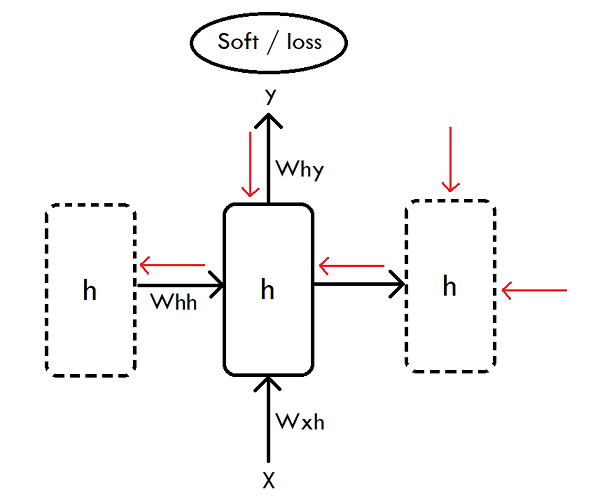

# Importing stuff

In [ ]:
import numpy as np

from google.colab import drive

# Functions

In [ ]:
"""
@param X_batch, y_batch: seq_len one-hot array
@param params: Wxh, Whh, Why, bh, by
@return last_h: last hidden state
#return dparams: dWxh, dWhh, dWhy, dbh, dby
      shapes
------------------
X_batch: (seq_len, chars)
y_batch: (seq_len, chars)
h_prev:  (h_units, 1)

h: (seq_len+1, h_units, 1) list
y: (seq_len, chars, 1) list
p: (seq_len, chars, 1) list

Wxh: (chars, h_units)
Whh: (h_units, h_units) (prev, current)
Why: (h_units, chars)
bh:  (h_units, 1)
by:  (chars, 1)

dy:  (chars, 1)
dWxh: (chars, h_units)
dWhh: (h_units, h_units) (prev, current)
dWhy: (h_units, chars)
dbh:  (h_units, 1)
dby:  (chars, 1)
dh:   (h_units, 1)
"""
def train_rnn(X_batch, y_batch, h_prev, params):
  assert X_batch.ndim == 2
  assert X_batch.shape == y_batch.shape
  assert h_prev.ndim == 2
  assert h_prev.shape[1] == 1
  # forward path
  h = {}
  y = {}
  p = {}
  batch_loss =  0

  Wxh, Whh, Why, bh, by = params

  h[-1] = h_prev
  for t in range(len(X_batch)):
    h[t] = np.tanh(np.dot(Wxh.T, X_batch[t].reshape(-1, 1)) + 
                   np.dot(Whh.T, h[t-1]) + bh)
    y[t] = np.dot(Why.T, h[t]) + by
    p[t] = np.exp(y[t]) / np.sum(np.exp(y[t]))
    batch_loss += -np.log(p[t][y_batch[t] == 1])
  
  batch_loss /= len(X_batch)

  # backward path
  dWxh = np.zeros_like(Wxh)
  dWhh = np.zeros_like(Whh)
  dWhy = np.zeros_like(Why)
  dbh = np.zeros_like(bh)
  dby = np.zeros_like(by)

  dh_next = 0
  for t in reversed(range(len(X_batch))):
    dy = p[t].copy()
    dy[y_batch[t] == 1] -= 1
    dWhy += np.dot(h[t], dy.T)
    dby += dy
    dh = np.dot(Why, dy) + dh_next
    dh = dh * (1 - h[t]**2)
    dWhh += np.dot(h[t-1], dh.T)
    dbh += dh
    dWxh += np.dot(X_batch[t].reshape(-1, 1), dh.T)
    dh_next = np.dot(Whh, dh)
    
  dparams = dWxh, dWhh, dWhy, dbh, dby
  for dparam in dparams:
    np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
  
  last_h = h[len(X_batch)-1]
  assert last_h.shape == h_prev.shape
  return last_h, dparams, batch_loss

In [ ]:
"""
@param x: first character, one-hot array
@param params: Wxh, Whh, Why, bh, by
@return new_text: an array containing one-hot representation of the text
      shapes
------------------
x: (chars, 1)
h: (h_units, 1)

y: (chars, 1)
p: (chars, 1)

Wxh: (chars, h_units)
Whh: (h_units, h_units) (prev, current)
Why: (h_units, chars)
bh:  (h_units, 1)
by:  (chars, 1)
"""
def create_text(x, h, params, len):
  assert x.ndim == 2
  assert h.ndim == 2
  assert x.shape[1] == 1
  assert h.shape[1] == 1
  Wxh, Whh, Why, bh, by = params
  new_text = np.zeros((len, x.shape[0]))
  new_text[0] = x.reshape(-1)
  for t in range(1, len):
    h = np.tanh(np.dot(Wxh.T, x) + np.dot(Whh.T, h) + bh)
    y = np.dot(Why.T, h) + by
    p = np.exp(y) / np.sum(np.exp(y))
    indx = np.random.choice(range(x.shape[0]), p=p.ravel())
    x = np.zeros_like(x)
    x[indx] = 1
    new_text[t] = x.reshape(-1)
  return new_text

In [ ]:
"""
@param x: list of characters
@return y: array of one-hot representation
"""
def char_to_hot(x, chars):
  y = np.zeros((len(x), len(chars)))
  char_to_indx = { ch:i for i,ch in enumerate(chars) }
  for i in range(len(x)):
    y[i, char_to_indx[x[i]]] = 1
  return y

In [ ]:
"""
@param x: array of one-hot representation
@return y: list of characters
"""
def hot_to_char(x, chars):
  indx_to_char = { i:ch for i,ch in enumerate(chars) }
  indxs = np.argmax(x, axis = 1)
  y = []
  for i in range(len(x)):
    y.append(indx_to_char[indxs[i]])
  return y

In [ ]:
def flat_params(params):
  Wxh, Whh, Why, bh, by = params
  params_flat = Wxh.reshape(-1)
  params_flat = np.concatenate((params_flat, Whh.reshape(-1), Why.reshape(-1),
                                bh.reshape(-1), by.reshape(-1)))
  return params_flat.reshape(-1, 1)

In [ ]:
def reshape_params(params_flat, params_sample):
  p0, p1 = 0, 0
  params = []
  for i in range(5):
    p0 = p1
    p1 = p1 + np.prod(params_sample[i].shape)
    params.append(params_flat[p0:p1].reshape(params_sample[i].shape))
  return params

In [ ]:
class Adagrad():
  def __init__(self, learning_rate = 0.1, beta = 0.999, step = 1, epsilon = 1e-7):
    self.learning_rate = learning_rate
    self.beta = beta
    self.step = step
    self.epsilon = epsilon
    self.moment = None
  
  """
        shapes
  ------------------
  vars:         (vars, 1)
  grads:        (vars, 1)
  vars_changes: (vars, 1)
  """
  def __call__(self, vars, grads, step = None):
    assert len(vars.shape) == 2
    assert vars.shape[1] == 1
    assert vars.shape == grads.shape
    if isinstance(step, int):
      self.step = step
    
    vars_changes = self.compute_changes(grads)
    return vars + vars_changes
  
  """
  @brief computes the amount changes needed to optimize variables
        shapes
  ------------------
  grads:        (vars, 1)
  changes: (vars, 1)
  """
  def compute_changes(self, grads, step = None):
    if self.moment is None:
      self.moment = np.zeros_like(grads)

    assert self.moment.shape == grads.shape
    
    if isinstance(step, int):
      self.step = step

    self.moment = self.beta * self.moment + (1 - self.beta) * grads * grads
    moment_unbiased = self.moment / (1 - self.beta ** self.step)

    # Adagrad
    changes = - self.learning_rate * grads / (np.sqrt(moment_unbiased + self.epsilon))
    return changes

# Initialization

In [ ]:
h_units = 100
seq_len = 25
learning_rate = 1e-1
epochs = 10

drive.mount('/content/drive')
text_adrs = '/content/drive/My Drive/Colab Stuff/Mini_char_RNN/William Shakespear.txt'

text = open(text_adrs, 'r').read()
chars = sorted(list(set(text)))
print("text has %d characters, %d unique." % (len(text), len(chars)))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
text has 5558552 characters, 107 unique.


# Train

In [ ]:
Wxh = np.random.randn(len(chars), h_units) * 0.01
Whh = np.random.randn(h_units, h_units) * 0.01
Why = np.random.randn(h_units, len(chars)) * 0.01
bh = np.zeros((h_units, 1))
by = np.zeros((len(chars), 1))

gen_freq = 1000
smooth_loss = 0
step = 0

optimizer = Adagrad(learning_rate)

for epoch_num in range(epochs):
  print("epoch %d started --------------------------" % epoch_num)
  h = np.zeros((h_units, 1))

  for pointer in range(0, len(text)-seq_len-1, seq_len):
    step += 1

    X_batch = text[pointer:pointer+seq_len]
    y_batch = text[pointer+1:pointer+1+seq_len]
    X_batch = char_to_hot(X_batch, chars)
    y_batch = char_to_hot(y_batch, chars)
    params = Wxh, Whh, Why, bh, by
    h, dparams, batch_loss = train_rnn(X_batch, y_batch, h, params)

    smooth_loss = 0.999 * smooth_loss + 0.001 * batch_loss

    params_flat = flat_params(params)
    dparams_flat = flat_params(dparams)
    params_flat = optimizer(params_flat, dparams_flat)
    params = reshape_params(params_flat, params)
    Wxh, Whh, Why, bh, by = params

    gen_freq -= 1
    if gen_freq == 0:
      start_hot = char_to_hot([text[pointer]], chars).T
      new_text = create_text(start_hot, h, params, 100)
      new_text = hot_to_char(new_text, chars)
      new_text_str = ""
      new_text_str = new_text_str.join(new_text)
      print("\n\nstep %d: smooth_loss = %.4f" % (step, smooth_loss))
      print("new text: ", new_text_str)
      gen_freq = 1000 + int(10*np.random.rand())

epoch 0 started --------------------------


step 1000: smooth_loss = 2.0197
new text:  nt cin ae0 piv mteebiolae b nlaubp,
Dg ce lseLeud es

The ane	phed sane ne, theinhe , ore nkomn 
 ta


step 2009: smooth_loss = 2.3565
new text:  h  Tan this thel,  hase thoxg fhane, foran eod  dith binh lare oth be chrthirtd riat hr mol sherd th


step 3011: smooth_loss = 2.3759
new text:  kluhde, pirylingad lor dak erer’t neawilRe, uy oike,
Dar lol toraYmeu3g ne aniny atemaje moD noit th


step 4013: smooth_loss = 2.3146
new text:  rth na seil breit ney tho cas corespidcis dill thath a nltcinds thy of woid,
mrath erce sho hat whas


step 5015: smooth_loss = 2.4566
new text:  As tnomont;angnght;
 yot.
ST]ay. m thay Thak anr ret.Tnom cole I thot dove.
AW be, on nou sov me;?




step 6023: smooth_loss = 2.4207
new text:  ut.
You erave and ernnat eer, Yom stilaen,
I ge yive foring anl ast and or, bowdalp’s.

Win. IW amo 


step 7024: smooth_loss = 2.3692
new text:  ; dirise’s whed te ery wolos Furgile

KeyboardInterrupt: ignored